In [1]:
import pandas as pd
from datetime import timedelta
from datetime import datetime
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv('/home/laol/task/test_query_2017_10_20.csv')

df.happened_at = pd.to_datetime(df.happened_at)
df = df. sort_values(['user_id', 'happened_at'])
df.index = range(df.shape[0])
df['first_in_session'] = df.user_id != df.user_id.shift(1)
df['prev_happened_at'] = df.happened_at.shift(1)
df.prev_happened_at[df.first_in_session] = None
df['time_diff'] = df.happened_at - df.prev_happened_at
df.first_in_session = df.first_in_session | (df.time_diff > timedelta(hours=1))


counter = -1
index = []
for i in df.first_in_session:
    if i:
        counter += 1
    index.append(counter)
    
df['session_id'] = pd.Series(index)
del df['prev_happened_at']
del df['time_diff']


session = ['rooms.homework-showcase', 
           'rooms.view.step.content', 
           'rooms.lesson.rev.step.content']

df['page_code'] = ''
df.page_code[df.page=='rooms.homework-showcase'] = '1'
df.page_code[df.page=='rooms.view.step.content'] = '2'
df.page_code[df.page=='rooms.lesson.rev.step.content'] = '3'

session_code = df.groupby('session_id')['page_code'].sum()

def check_session(string):
    pattern = re.compile("[23]*1[13]*2[12]*3[123]*")
    return pattern.match(string)
result = session_code.apply(lambda x: True if check_session(x) else False)
result = result.index[result]

/home/laol/env3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/laol/env3/lib/python3.5/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/laol/env3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/laol/env3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [3]:
df_session = pd.DataFrame()
df_session['start'] = (df.groupby('session_id')
                       ['happened_at'].min())
df_session['end'] = (df.groupby('session_id')
                     ['happened_at'].max() + timedelta(hours=1))
df_session = df_session.loc[result]
df_session['length_session'] = df_session.end - df_session.start
df_session['length_session_in_seconds'] = (df_session.length_session
                                           .apply(lambda x: x.seconds))

In [4]:
df.head()

,user_id,page,happened_at,first_in_session,session_id,page_code
0,1209,rooms.homework-showcase,2017-03-01 11:17:10.596,True,0,1
1,1209,rooms.student-showcase,2017-03-01 11:17:16.128,False,0,
2,1978,rooms.view.step.content,2017-03-01 10:13:00.818,True,1,2
3,1978,rooms.homework-showcase,2017-03-01 10:42:09.250,False,1,1
4,1978,rooms.view.step.content,2017-03-01 10:42:15.389,False,1,2


In [5]:
df_session.describe()

,length_session,length_session_in_seconds
count,378,378.000000
mean,0 days 02:42:20.022076,9739.523810
std,0 days 00:59:36.319315,3576.291864
min,0 days 01:06:04.154000,3964.000000
25%,0 days 02:10:13.192500,7812.750000
50%,0 days 02:33:54.935000,9234.500000
75%,0 days 03:01:23.019750,10882.750000
max,0 days 15:03:55.970000,54235.000000


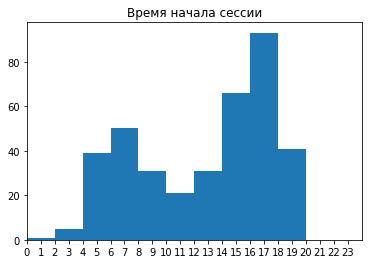

In [6]:
def chart(occurance_list):
    hour_list = [t.hour for t in occurance_list]
    numbers=[x for x in range(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,24)
    plt.hist(hour_list)
    plt.title('Время начала сессии')
    plt.show()
chart(df_session.start)

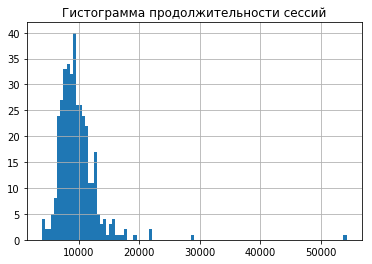

In [7]:
df_session.length_session_in_seconds.hist(bins=100)
plt.title('Гистограмма продолжительности сессий')

Есть 2 странные, длинные сессии, и эти две сессии принадлежат одному пользователю

In [8]:
df_session[df_session.length_session_in_seconds > 25000]

,start,end,length_session,length_session_in_seconds
session_id,,,,
1869,2017-03-01 00:22:48.286,2017-03-01 15:26:44.256,15:03:55.970000,54235
1870,2017-03-01 16:22:50.513,2017-03-02 00:26:31.308,08:03:40.795000,29020


In [9]:
count_activity = df.groupby('session_id')['page_code'].count() 

Также есть сессии с подозрительно высокой активностью

In [10]:
count_activity[count_activity > 300]

session_id
1869    336
2358    408
2360    408
2364    612
Name: page_code, dtype: int64

Причем, сессия, которая является длинной, также является высокоактивной - ее id - **1869**